In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.under_sampling import EditedNearestNeighbours
from ctgan import CTGAN
import numpy as np

In [2]:
df = pd.read_csv('ecom-user-churn-data.csv')

In [3]:
columns_to_remove = df.columns[df.columns.str.startswith('int_cat') | df.columns.str.endswith('_n')]
df = df.drop(columns=columns_to_remove)

In [4]:
df = df.drop(columns=['ses_n_r', 'ses_rec_cv', 'rev_sum', 'time_to_tran'])

In [5]:
df.head()

,visitorid,ses_rec,ses_rec_avg,ses_rec_sd,user_rec,int_n_r,tran_n_r,rev_sum_r,major_spend_r,int_itm_n_avg,ses_mo_avg,ses_mo_sd,ses_ho_avg,ses_ho_sd,ses_wknd_r,ses_len_avg,time_to_int,target_class
0,89,23.0,16.0,0.0,39.0,1.500000,0.0,0.0,0.0,1.5,7.000000,0.000000,11.000000,7.071068,0.500000,2.866667,1.911111,1
1,251,23.0,61.0,0.0,85.0,1.000000,0.0,0.0,0.0,1.0,6.000000,1.414214,13.500000,2.121320,1.000000,0.000000,0.000000,1
2,270,14.0,0.1,0.3,21.0,1.181818,0.0,0.0,0.0,1.0,7.454546,0.522233,12.636364,4.342182,0.363636,1.104545,0.934615,1
3,298,11.0,13.0,0.0,24.0,2.000000,0.0,0.0,0.0,1.5,7.500000,0.707107,11.500000,4.949748,0.000000,0.508333,0.254167,1
4,474,16.0,26.0,0.0,43.0,1.000000,0.0,0.0,0.0,1.0,7.000000,0.000000,19.500000,2.121320,0.500000,0.000000,0.000000,1


In [6]:
def create_pi_chart(df):
    value_counts = df['target_class'].value_counts()
    plt.figure(figsize=(10, 8))
    plt.pie(
        value_counts,
        labels=[f'Churn (1): {value_counts[1]} rows', f'Not churn (0): {value_counts[0]} rows'],
        autopct='%1.1f%%', 
        startangle=140
    )
    plt.title('Distribution of Ratings')
    plt.show()

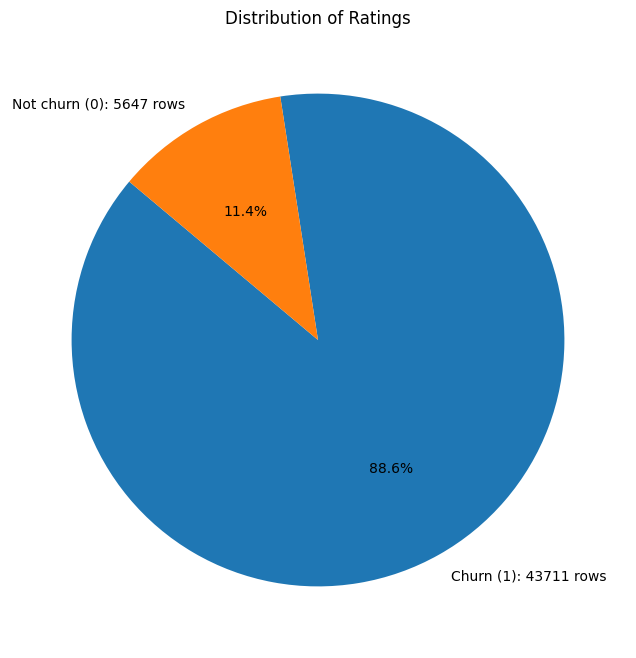

In [8]:
create_pi_chart(df)

In [10]:
def get_synthetic_data(min_class, n_generated_data):
    batch_size = 5000
    epochs = 300

    model = CTGAN(
        batch_size=batch_size,
        epochs=epochs, 
        verbose=True
    )
    history = model.fit(min_class)

    plt.plot(history['Epoch'], history['Generator Loss'], label='Generator Loss')
    plt.plot(history['Epoch'], history['Discriminator Loss'], label='Discriminator Loss')
    plt.legend(loc="upper right")
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.show()

    generated_df = model.sample(n_generated_data)
    generated_df = abs(generated_df)
    generated_df['ses_rec'] = round(generated_df['ses_rec'])
    generated_df['user_rec'] = round(generated_df['user_rec'])
    return generated_df

def add_to_dataset(df, generated_df, target_label):
    data= pd.concat([df, generated_df])
    enn = EditedNearestNeighbours(n_neighbors=3)
    X = data.drop([target_label],axis=1)
    y = data[target_label]
    X, y = enn.fit_resample(X, y)
    final_df = pd.concat([X, y], axis=1)
    return final_df


In [11]:
min_class = df.loc[df['target_class'] == 0]
maj_class = df.loc[df['target_class'] == 1]
n_synthetic_samples = (maj_class.shape[0] - min_class.shape[0])*2

Gen. (-1.16) | Discrim. (-0.09): 100%|██████████| 300/300 [01:44<00:00,  2.86it/s]


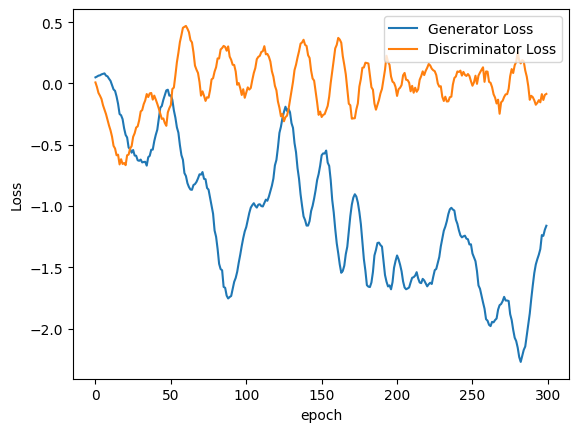

In [12]:
fake_df = get_synthetic_data(min_class, n_synthetic_samples)

In [43]:
fake_df

,visitorid,ses_rec,ses_rec_avg,ses_rec_sd,user_rec,int_n_r,tran_n_r,rev_sum_r,major_spend_r,int_itm_n_avg,ses_mo_avg,ses_mo_sd,ses_ho_avg,ses_ho_sd,ses_wknd_r,ses_len_avg,time_to_int,target_class
0,386604,2.0,43.814786,0.474108,50.0,1.462692,0.000152,474.321337,0.000242,1.009988,8.054338,0.527449,12.389374,4.702925,0.001963,0.217226,0.048045,0
1,465663,17.0,0.799663,5.829522,7.0,2.922360,0.003143,487.367968,0.002921,0.994135,7.223467,0.710731,8.404381,9.724012,0.002376,0.091918,0.803461,0
2,864804,17.0,42.263280,0.070671,24.0,1.757138,0.001732,242.482247,0.041762,2.037616,6.054147,2.761996,12.739095,3.357285,0.466389,0.742869,0.713047,0
3,32139,3.0,2.026903,32.279731,29.0,0.986791,0.005070,427.099091,0.001427,0.992782,6.128548,0.772287,6.564029,3.823394,0.005362,16.976749,0.512844,0
4,1232010,3.0,0.285020,0.232393,21.0,1.452358,0.004119,68.850104,0.001837,1.027317,7.489663,0.000613,13.062211,1.617604,0.257742,10.643472,0.014463,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76123,692894,25.0,3.090870,2.100862,3.0,0.954999,0.006848,121.960201,0.000321,1.073555,8.065675,0.028949,6.645136,0.408962,0.082335,0.019146,0.039632,0
76124,698516,13.0,22.739407,0.215904,0.0,7.243519,0.001566,378.223055,0.004484,2.051316,6.848143,0.788106,11.793597,3.388815,0.005880,0.025860,0.054914,0
76125,1182214,8.0,1.927082,9.214093,30.0,3.656491,0.005018,467.710669,0.002561,0.952694,8.055339,0.025594,5.331155,3.077403,0.427580,0.304740,0.500916,0
76126,61276,8.0,20.635984,1.324145,22.0,1.873838,0.006927,375.440958,0.001965,1.031133,6.842518,0.012393,10.030125,2.081941,0.001476,18.831853,0.145401,0


In [44]:
augmented_df = add_to_dataset(df, fake_df, 'target_class')

In [45]:
augmented_df.to_csv('augmented-ecom-churn-data.csv', encoding='utf-8')

In [46]:
augmented_df

,visitorid,ses_rec,ses_rec_avg,ses_rec_sd,user_rec,int_n_r,tran_n_r,rev_sum_r,major_spend_r,int_itm_n_avg,ses_mo_avg,ses_mo_sd,ses_ho_avg,ses_ho_sd,ses_wknd_r,ses_len_avg,time_to_int,target_class
0,64931,2.0,2.000000,3.807887,98.0,4.000000,0.121951,4423.9023,0.024390,2.487805,5.853659,1.062096,15.292683,4.290943,0.390244,7.451220,1.862805,0
1,72373,13.0,8.000000,0.000000,21.0,3.500000,0.500000,9300.0000,0.500000,1.500000,7.500000,0.707107,18.500000,2.121320,0.500000,17.175000,4.907143,0
2,150651,8.0,9.444445,11.596083,97.0,5.700000,0.800000,14976.0000,0.100000,3.300000,5.900000,1.100505,19.900000,1.523884,0.200000,7.818333,1.371638,0
3,500130,12.0,6.000000,6.164414,36.0,5.600000,0.800000,17160.0000,0.200000,4.400000,7.400000,0.547723,12.400000,8.848729,0.600000,3.943333,0.704167,0
4,543762,1.0,1.250000,2.046338,15.0,3.888889,0.222222,17733.3340,0.111111,2.000000,8.000000,0.000000,17.888890,3.179797,0.333333,8.664815,2.228095,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108805,1406824,14.0,73.000000,0.000000,87.0,1.000000,0.000000,0.0000,0.000000,1.000000,6.500000,2.121320,10.500000,2.121320,0.000000,0.000000,0.000000,1
108806,1406906,19.0,13.000000,0.000000,32.0,2.000000,0.000000,0.0000,0.000000,1.500000,7.000000,0.000000,12.000000,5.656854,0.000000,4.016667,2.008333,1
108807,1406914,21.0,0.666667,0.942809,23.0,3.500000,0.000000,0.0000,0.000000,3.000000,7.000000,0.000000,13.250000,2.629955,0.750000,6.362500,1.817857,1
108808,1407221,1.0,0.000000,0.000000,2.0,1.000000,0.000000,0.0000,0.000000,1.000000,8.000000,0.000000,14.500000,7.778174,1.000000,0.000000,0.000000,1


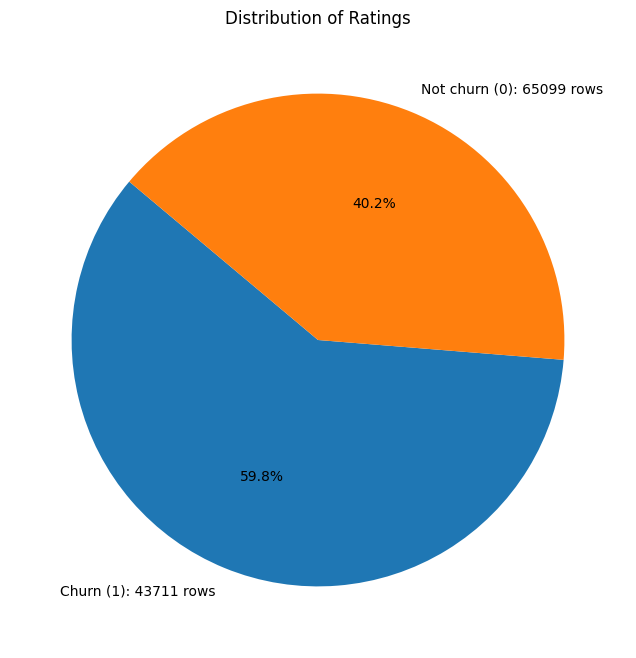

In [47]:
create_pi_chart(augmented_df)

In [48]:
augmented_df.shape

(108810, 18)